# ATP Tennis Data - Player Diff Stats + One Hot Encoding (All Categorical Data) + Matchup


In our previous [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/7.2-atp_diff-ohe-matchup.ipynb), we saw that adding match data gave us around a 0.5% boost in accuracy from the player stats diff + one hot encoding (all categories) data set for Decision Tree

In this notebook, we will add matchup history between player 1 and 2 to our best performing dataset - player stats diff + one hot encoding (player id's only)

Data that we obtained for each player:

* matchups won - ie, out of last 5 matchups - how many matches did p1 win
* matchups lost
* matchups sets won
* matchups sets lost
* matchups games won
* matchups games lost
* matchups win percentage
* matchups sets won percentage
* matchups games won percentage

We will see if this data helps improve our models

### Results from Decision Tree Classifier with player diff + one hot encoded player ID's:

```
Model Score: 0.9372638963842418

              precision    recall  f1-score   support

        Loss       0.93      0.94      0.94      7378
         Win       0.94      0.93      0.94      7446

    accuracy                           0.94     14824
   macro avg       0.94      0.94      0.94     14824
weighted avg       0.94      0.94      0.94     14824
```

# Summary of Results


* Decision Tress is still our best model, although adding this data decreased our performance to be about 1% (back to diff+ohe_player performance). Our accuracty for both wins and losses are down to 92% now with lower recall as well

Player Diff + One Hot Encoding (All Categories) + Player History
```
Model Score: 0.9191851052347545

              precision    recall  f1-score   support

        Loss       0.92      0.92      0.92      7378
         Win       0.92      0.92      0.92      7446

    accuracy                           0.92     14824
   macro avg       0.92      0.92      0.92     14824
weighted avg       0.92      0.92      0.92     14824
```

Player Diff + One Hot Encoding (All Categories) + Player Matchup
```
Model Score: 0.9247841338370211

              precision    recall  f1-score   support

        Loss       0.92      0.93      0.92      7378
         Win       0.93      0.92      0.92      7446

    accuracy                           0.92     14824
   macro avg       0.92      0.92      0.92     14824
weighted avg       0.92      0.92      0.92     14824
```


* No change in performance for Ada Boost or Logistic regression or Gradient Boost
* Around 5% decrease in accuracy for KNN and Random Forest


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "diff-ohe_player-matchup_percentage"


# update this
FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-diff-ohe_player-matchup5_percentage.csv'

START_YEAR = 1998
END_YEAR = 2019

MODEL_TEMPLATE_NAME = f'{START_YEAR}-{END_YEAR}-{DESCRIPTION}.pkl'

LABEL_COL = 'p1_winner'

# random seed
RSTATE = 1
N_JOBS = 4
MAX_ITER = 100



ModelWrapper.init(description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR, 
                 model_file_format = MODEL_TEMPLATE_NAME)

# Let's Create The Data

Since we didn't create this ahead of time, we are going to create it now by taking matchup columns from our history+matchup data and concatenating it with our existing dataset. We are going to exclude any redudant data and only keep the percentage columns

In [2]:
import re


if not os.path.exists(FEATURE_FILE):
    OHE_PLAYER_FILE = f'../datasets/atp_matches_1985-2019_features-diff-ohe_player.csv'
    ohe = pd.read_csv(OHE_PLAYER_FILE)
    MATCHUP_FILE = f'../datasets/atp_matches_1985-2019_features-diff-ohe-matchup5.csv'
    matchups = pd.read_csv(MATCHUP_FILE)
    
    # make sure the shapes match
    print(f'ohe {ohe.shape} matchups {matchups.shape}')

    matchup_cols = [col for col in matchups.columns if re.search("matchup", col)]
    print(matchup_cols)
    
    matchup_percentage_cols = [col for col in matchup_cols if re.search("percentage", col)]
    print(matchup_percentage_cols)

    keep = matchups[matchup_percentage_cols]
    # should be features x 14
    print(keep.shape)

    ohe_plus_matchup = pd.concat([ohe, keep], axis=1, copy=True)
    print(ohe_plus_matchup.shape)

    ohe_plus_matchup.to_csv(FEATURE_FILE, index=False)

ohe (99955, 4838) matchups (99955, 5284)


# Load Data

In [5]:
X_train, X_test, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR)

(59293, 4843)


# Logistic Regression

In [6]:

# train our model

lr = ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_lr = lr.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

Model Score: 0.6725580140313006

              precision    recall  f1-score   support

        Loss       0.67      0.67      0.67      7378
         Win       0.67      0.68      0.68      7446

    accuracy                           0.67     14824
   macro avg       0.67      0.67      0.67     14824
weighted avg       0.67      0.67      0.67     14824

      Loss   Win
Loss  4919  2459
Win   2395  5051


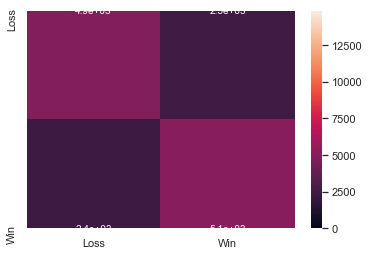

In [7]:
lr.analyze()

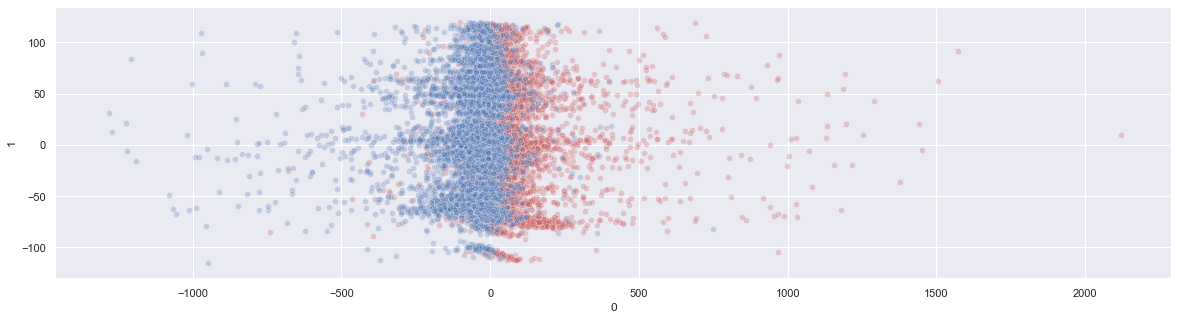

In [8]:
ju.plot_2d(X_test, y_predict_lr)

In [9]:
lr.save()

# KNN

In [10]:

# train our model

knn = ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_knn = knn.predict()

Model Score: 0.7890582838640043

              precision    recall  f1-score   support

        Loss       0.77      0.82      0.79      7378
         Win       0.81      0.76      0.78      7446

    accuracy                           0.79     14824
   macro avg       0.79      0.79      0.79     14824
weighted avg       0.79      0.79      0.79     14824

      Loss   Win
Loss  6049  1329
Win   1798  5648


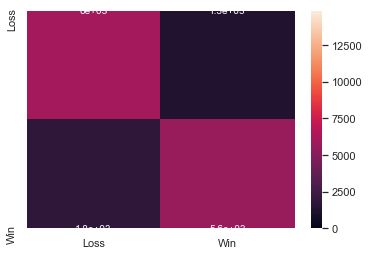

In [11]:
knn.analyze()

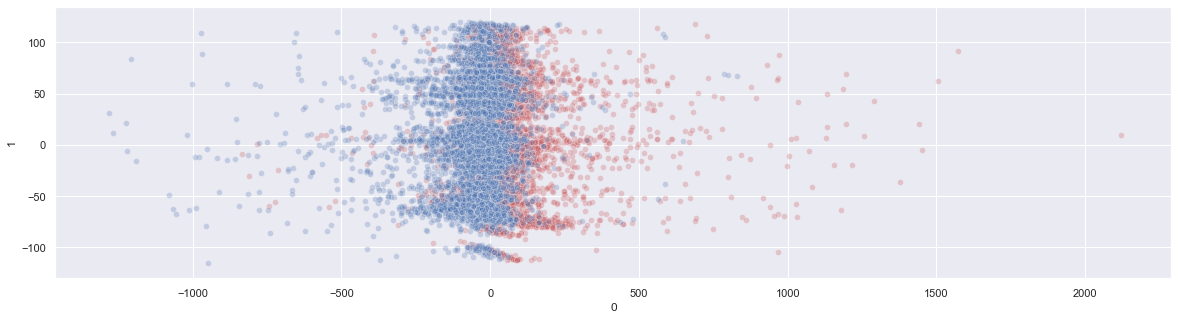

In [12]:
ju.plot_2d(X_test, y_predict_knn)

In [13]:
knn.save()

# Decision Tree

In [14]:

# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_dt = dt.predict()

Model Score: 0.926605504587156

              precision    recall  f1-score   support

        Loss       0.92      0.93      0.93      7378
         Win       0.93      0.92      0.93      7446

    accuracy                           0.93     14824
   macro avg       0.93      0.93      0.93     14824
weighted avg       0.93      0.93      0.93     14824

      Loss   Win
Loss  6868   510
Win    578  6868


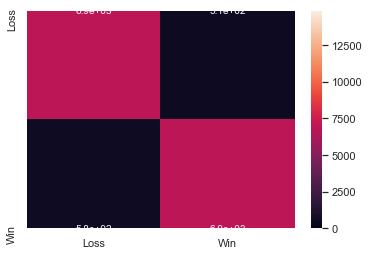

In [15]:
dt.analyze()

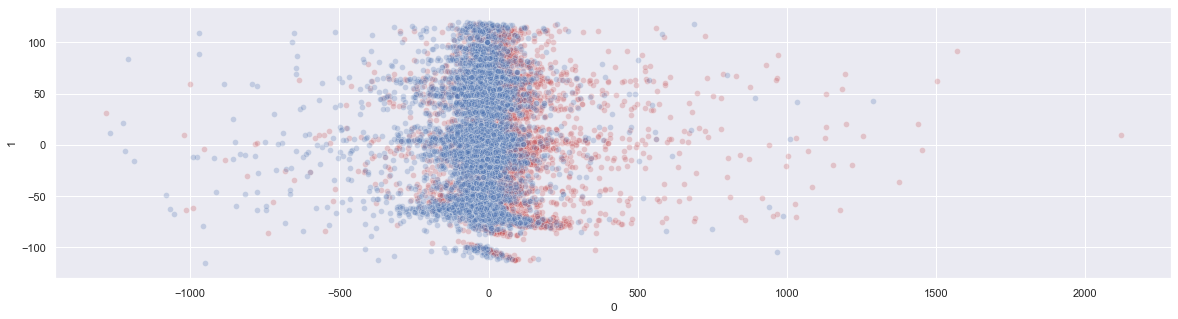

In [16]:
ju.plot_2d(X_test, y_predict_dt)

In [17]:
dt.save()

# Random Forest Classifier

In [18]:

# train our model

rf = ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_rf = rf.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.7801538046411225

              precision    recall  f1-score   support

        Loss       0.76      0.82      0.79      7378
         Win       0.81      0.74      0.77      7446

    accuracy                           0.78     14824
   macro avg       0.78      0.78      0.78     14824
weighted avg       0.78      0.78      0.78     14824

      Loss   Win
Loss  6040  1338
Win   1921  5525


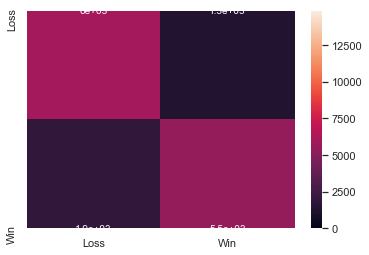

In [19]:
rf.analyze()

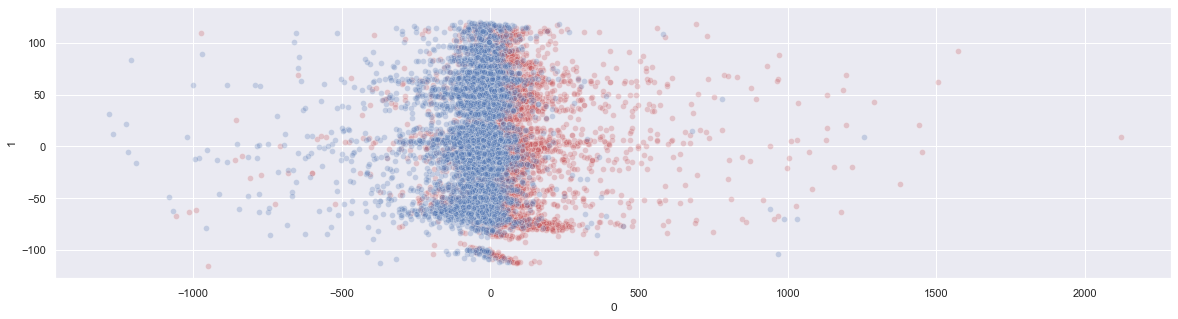

In [20]:
ju.plot_2d(X_test, y_predict_rf)

In [21]:
rf.save()

# Gradient Boosting

In [22]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3153            8.44m
         2           1.2572            8.35m
         3           1.2087            8.19m
         4           1.1699            8.08m
         5           1.1376            7.97m
         6           1.1111            7.86m
         7           1.0795            7.76m
         8           1.0528            7.67m
         9           1.0318            7.56m
        10           1.0104            7.47m
        20           0.8858            6.60m
        30           0.8207            5.74m
        40           0.7839            4.89m
        50           0.7628            4.10m
        60           0.7463            3.26m
        70           0.7199            2.44m
        80           0.7005            1.62m
        90           0.6743           48.84s
       100           0.6613            0.00s


Model Score: 0.8599568267674043

              precision    recall  f1-score   support

        Loss       0.84      0.89      0.86      7378
         Win       0.88      0.83      0.86      7446

    accuracy                           0.86     14824
   macro avg       0.86      0.86      0.86     14824
weighted avg       0.86      0.86      0.86     14824

      Loss   Win
Loss  6533   845
Win   1231  6215


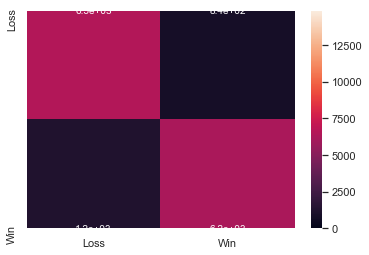

In [23]:
gb.analyze()

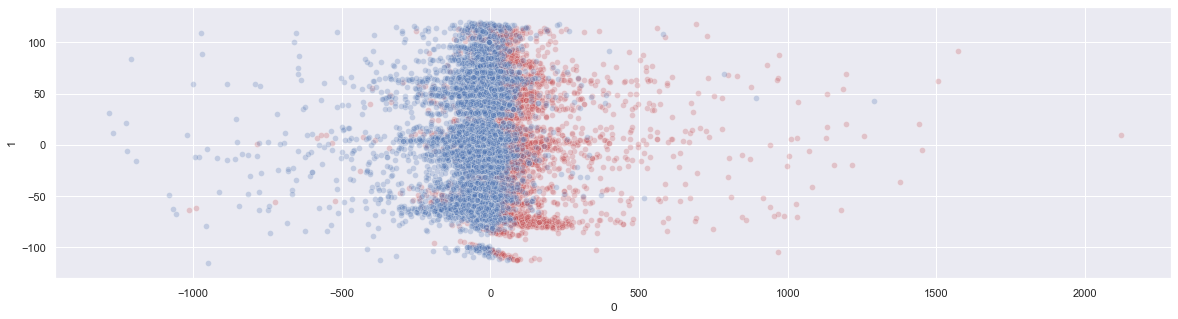

In [24]:
ju.plot_2d(X_test, y_predict_gb)

In [25]:
gb.save()

# AdaBoost

In [26]:
ab = ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_ab = ab.predict()

Model Score: 0.7600512682137075

              precision    recall  f1-score   support

        Loss       0.74      0.79      0.77      7378
         Win       0.78      0.73      0.75      7446

    accuracy                           0.76     14824
   macro avg       0.76      0.76      0.76     14824
weighted avg       0.76      0.76      0.76     14824

      Loss   Win
Loss  5851  1527
Win   2030  5416


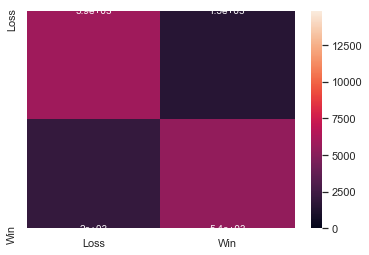

In [27]:
ab.analyze()

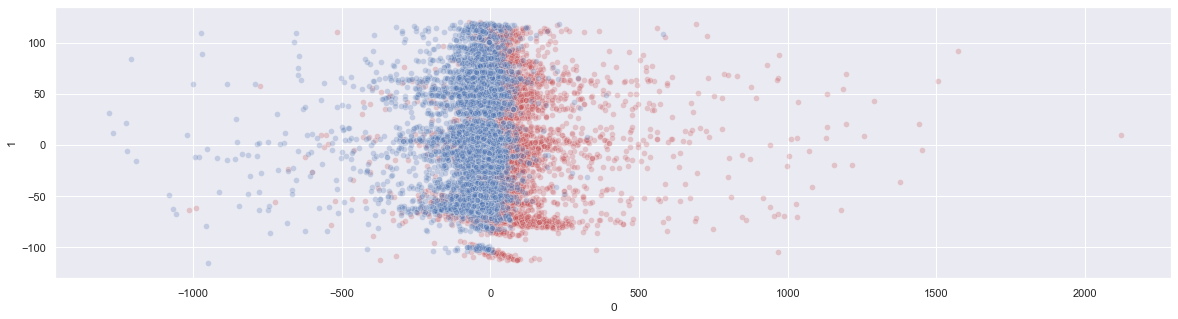

In [28]:
ju.plot_2d(X_test, y_predict_ab)

In [29]:
ab.save()

# Results

* Decision Tress is still our best model, although adding this data decreased our performance to be about 1% (from diff+ohe_player performance)
* No change in performance for Ada Boost or Logistic regression or Gradient Boost
* Around 5% decrease in accuracy for KNN and Random Forest

In [30]:
report = pd.read_csv(ModelWrapper.report_file)
report.tail(5)

,model,description,data_file,start_year,accuracy,confusion_matrix,classification_report,model_file
43,KNeighborsClassifier,diff-ohe_player-matchup_percentage,../datasets/atp_matches_1985-2019_features-dif...,1998,0.789058,"{""0"": {""0"": 6049, ""1"": 1798}, ""1"": {""0"": 1329,...","{""Loss"": {""precision"": 0.7708678475850643, ""re...",../models/kneighborsclassifier-1998-2019-diff-...
44,DecisionTreeClassifier,diff-ohe_player-matchup_percentage,../datasets/atp_matches_1985-2019_features-dif...,1998,0.926606,"{""0"": {""0"": 6868, ""1"": 578}, ""1"": {""0"": 510, ""...","{""Loss"": {""precision"": 0.9223744292237442, ""re...",../models/decisiontreeclassifier-1998-2019-dif...
45,RandomForestClassifier,diff-ohe_player-matchup_percentage,../datasets/atp_matches_1985-2019_features-dif...,1998,0.780154,"{""0"": {""0"": 6040, ""1"": 1921}, ""1"": {""0"": 1338,...","{""Loss"": {""precision"": 0.7586986559477452, ""re...",../models/randomforestclassifier-1998-2019-dif...
46,GradientBoostingClassifier,diff-ohe_player-matchup_percentage,../datasets/atp_matches_1985-2019_features-dif...,1998,0.859957,"{""0"": {""0"": 6533, ""1"": 1231}, ""1"": {""0"": 845, ...","{""Loss"": {""precision"": 0.8414477073673364, ""re...",../models/gradientboostingclassifier-1998-2019...
47,AdaBoostClassifier,diff-ohe_player-matchup_percentage,../datasets/atp_matches_1985-2019_features-dif...,1998,0.760051,"{""0"": {""0"": 5851, ""1"": 2030}, ""1"": {""0"": 1527,...","{""Loss"": {""precision"": 0.742418474812841, ""rec...",../models/adaboostclassifier-1998-2019-diff-oh...


Text(0.5, 1.0, 'Model Accuracy')

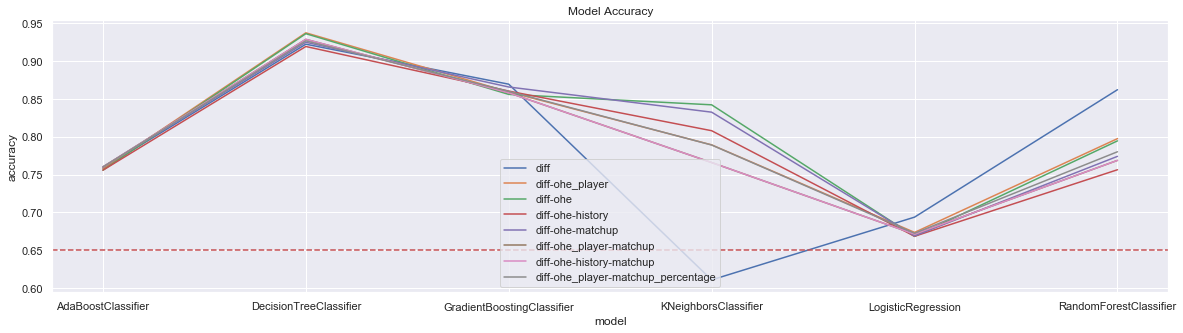

In [31]:
f, a = plt.subplots(1, 1, figsize=(20, 5))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    sns.lineplot(x="model", y="accuracy", data=report_desc, label=desc)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")

## Let's take a closer look at Decision Tree

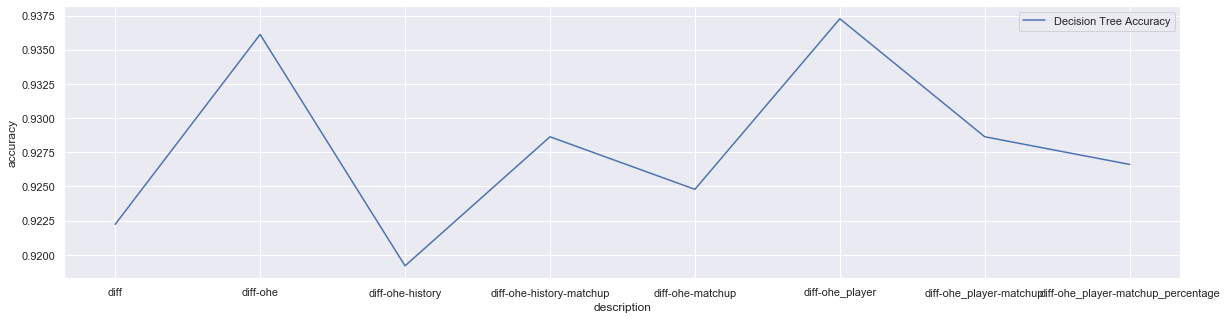

In [32]:
dt_report = report[report.model == 'DecisionTreeClassifier'].sort_values("accuracy")
f, a = plt.subplots(1, 1, figsize=(20, 5))
sns.lineplot(x="description", y="accuracy", data=dt_report, label="Decision Tree Accuracy")
